/home/tjudd/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Done


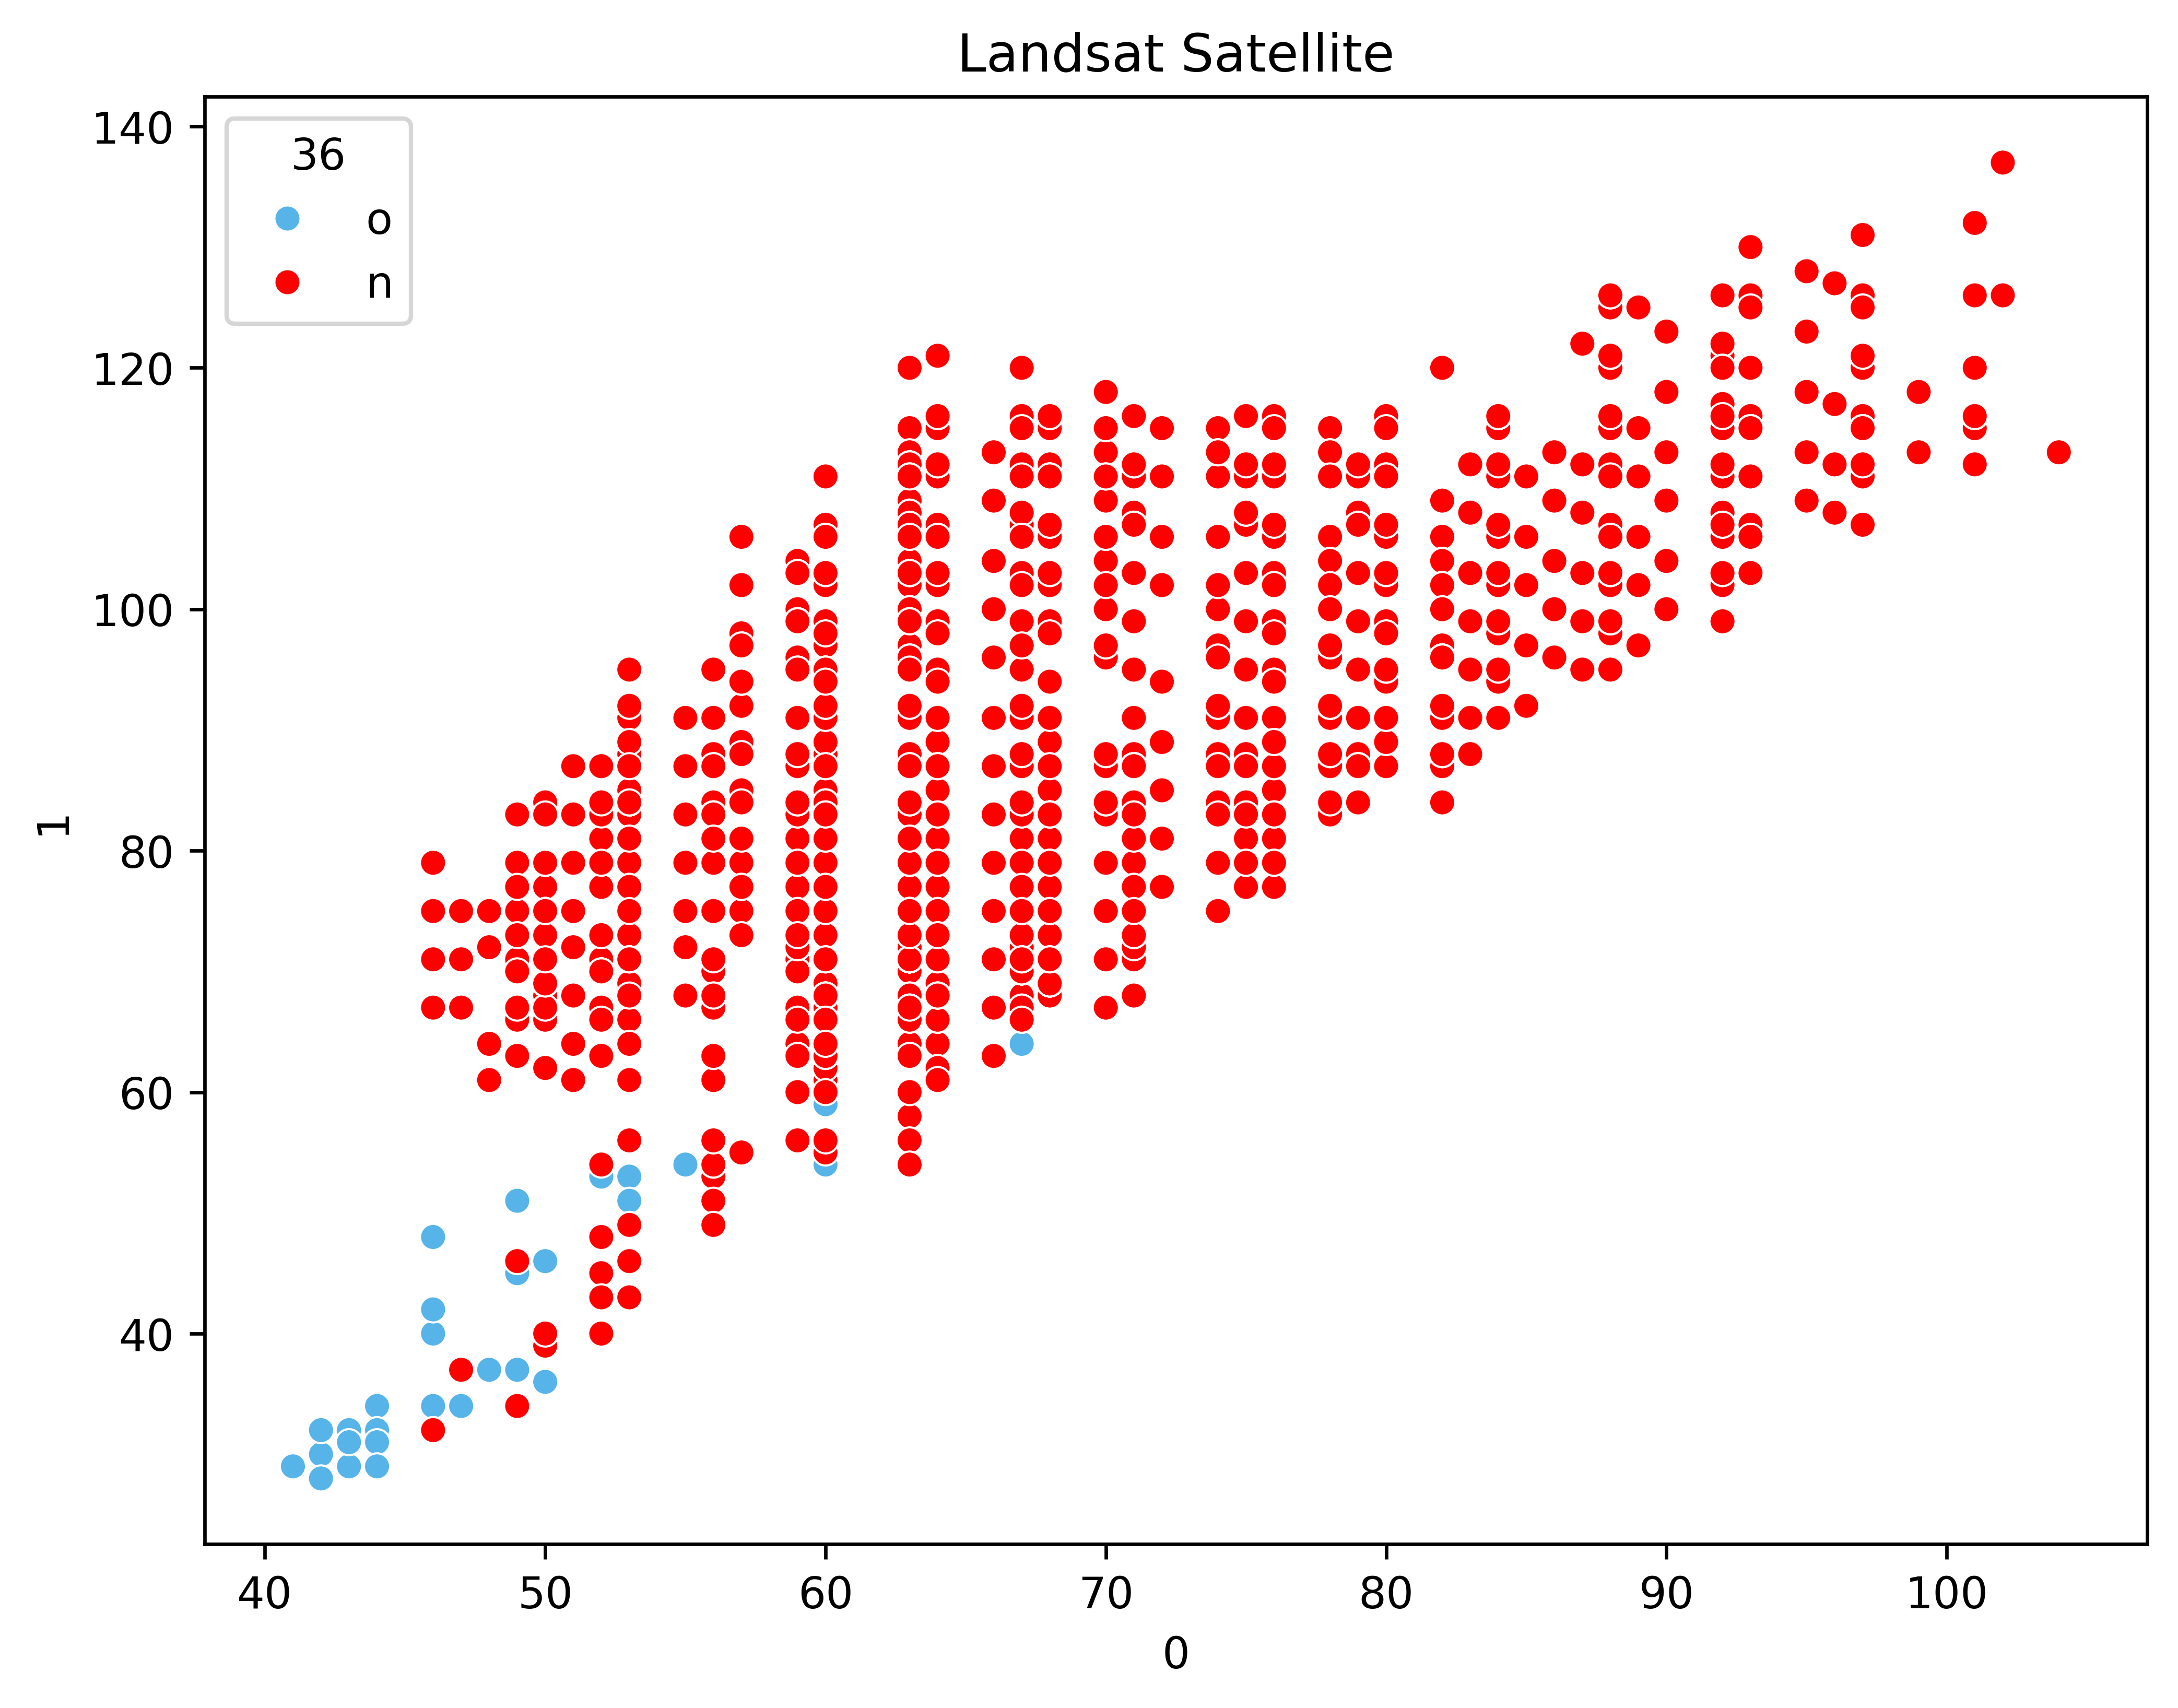

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, adjusted_rand_score
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, cut_tree
# Load the dataset
satellite_data = pd.read_csv("/mnt/c/Users/tjudd/downloads/IoT_testing/HLMCC_python/Datasets/original_Dataset/satellite-unsupervised-ad.csv", header=None)
# Normalization
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(satellite_data.iloc[:, :36])
normalized_satellite_data = satellite_data.copy()
normalized_satellite_data.iloc[:, :36] = normalized_data
normalized_satellite_data.fillna(0, inplace=True)

# Visualization before clustering
plt.figure(figsize=(8, 6), dpi=600)
Label = satellite_data.iloc[:, 36]
sns.scatterplot(x=satellite_data.iloc[:, 0], y=satellite_data.iloc[:, 1], hue=Label, palette=["#56B4E9", "red"])
plt.title("Landsat Satellite")
plt.savefig("LandsatSatellite.tiff", dpi=600)

# Affinity Propagation
def negDistMat(X, r=1):
    return -squareform(pdist(X, 'euclidean'))
    
sim = negDistMat(normalized_satellite_data.iloc[:, :36])
af = AffinityPropagation().fit(sim)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
print('Done')

In [11]:
agg_clustering = AgglomerativeClustering(n_clusters=2, metric ='cosine',linkage='complete')
agg_labels = agg_clustering.fit_predict(normalized_satellite_data.iloc[:, :36])

# Convert cluster labels using cut_tree and rename to "Normal" and "Anomaly"
aggres = linkage(normalized_satellite_data.iloc[:, :36], method='average')
Label_HAP = cut_tree(aggres, n_clusters=[2]).flatten()
Label_HAP = ["Anomaly" if label == 0 else "Normal" for label in Label_HAP]

silhouette_vals = silhouette_samples(normalized_satellite_data.iloc[:, :36], agg_labels)# Create a DataFrame to relate labels with their silhouette values
silhouette_avg = np.mean(silhouette_vals)

print('Done')

Done


In [12]:
print(pd.crosstab(Label_HAP, satellite_data.iloc[:, 36]))

36          n   o
row_0            
Anomaly     0  33
Normal   5025  42


Silhouette Score: 0.4979321931504867


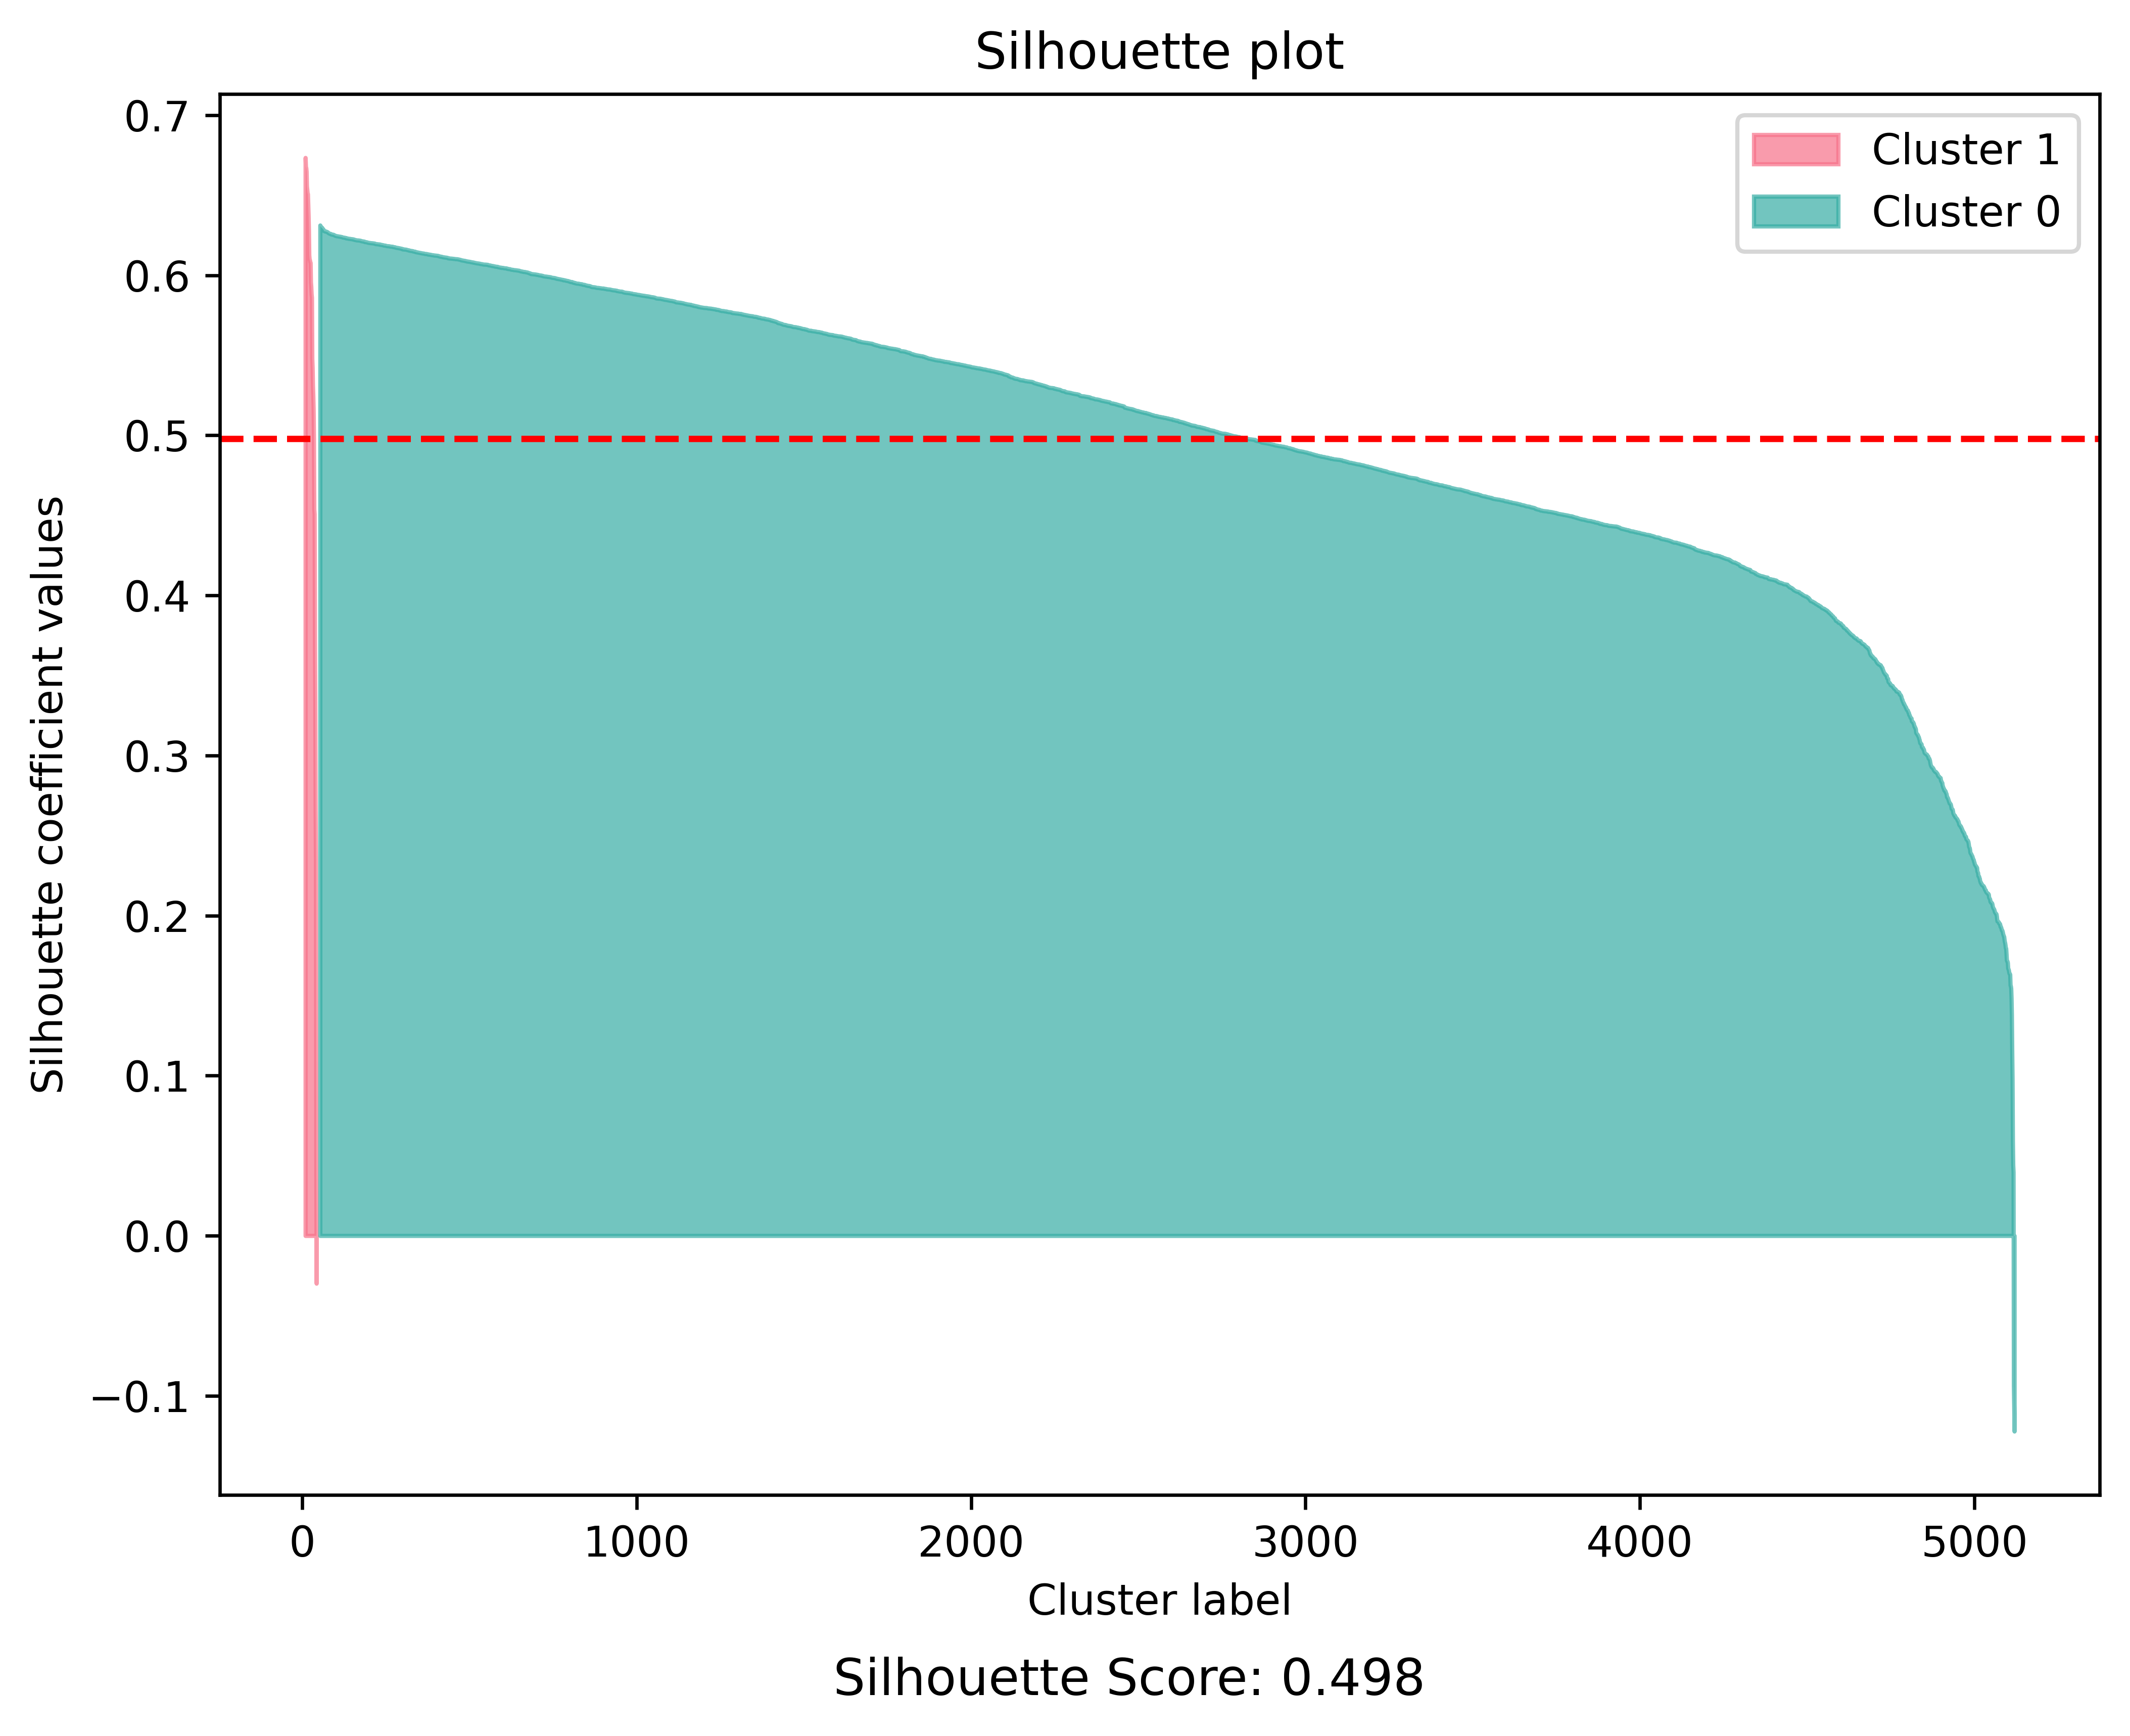

In [28]:
# Compute silhouette samples and silhouette score
silhouette_vals = silhouette_samples(normalized_satellite_data.iloc[:, :36], agg_labels)
silhouette_avg = np.mean(silhouette_vals)


print('Silhouette Score:', silhouette_avg)
        
# Plotting the silhouette plot
plt.figure(figsize=(8, 6), dpi=600)
x_lower = 10
for i in range(2):
    ith_cluster_silhouette_values = silhouette_vals[agg_labels == (1 - i)]  # Flip the cluster indices
    ith_cluster_silhouette_values = np.sort(ith_cluster_silhouette_values)[::-1]  # Sort in descending order
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    x_upper = x_lower + size_cluster_i
    
    color = sns.color_palette("husl", 2)[i]
    plt.fill_between(np.arange(x_lower, x_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7, label=f'Cluster {1 - i}')
    x_lower = x_upper + 10  # Add space between clusters

plt.axhline(y=silhouette_avg, color="red", linestyle="--")  # Average silhouette score
plt.ylabel("Silhouette coefficient values")
plt.xlabel("Cluster label")
plt.legend()
plt.figtext(0.5, 0, f'Silhouette Score: {round(silhouette_avg, 3)}', ha="center", fontsize=12)
plt.title(f"Silhouette plot")
plt.savefig(f"HAP_sil.tiff")
plt.show()
plt.close()

Unique values in the column:  ['o' 'n']
Adjusted Rand Index:  0.0


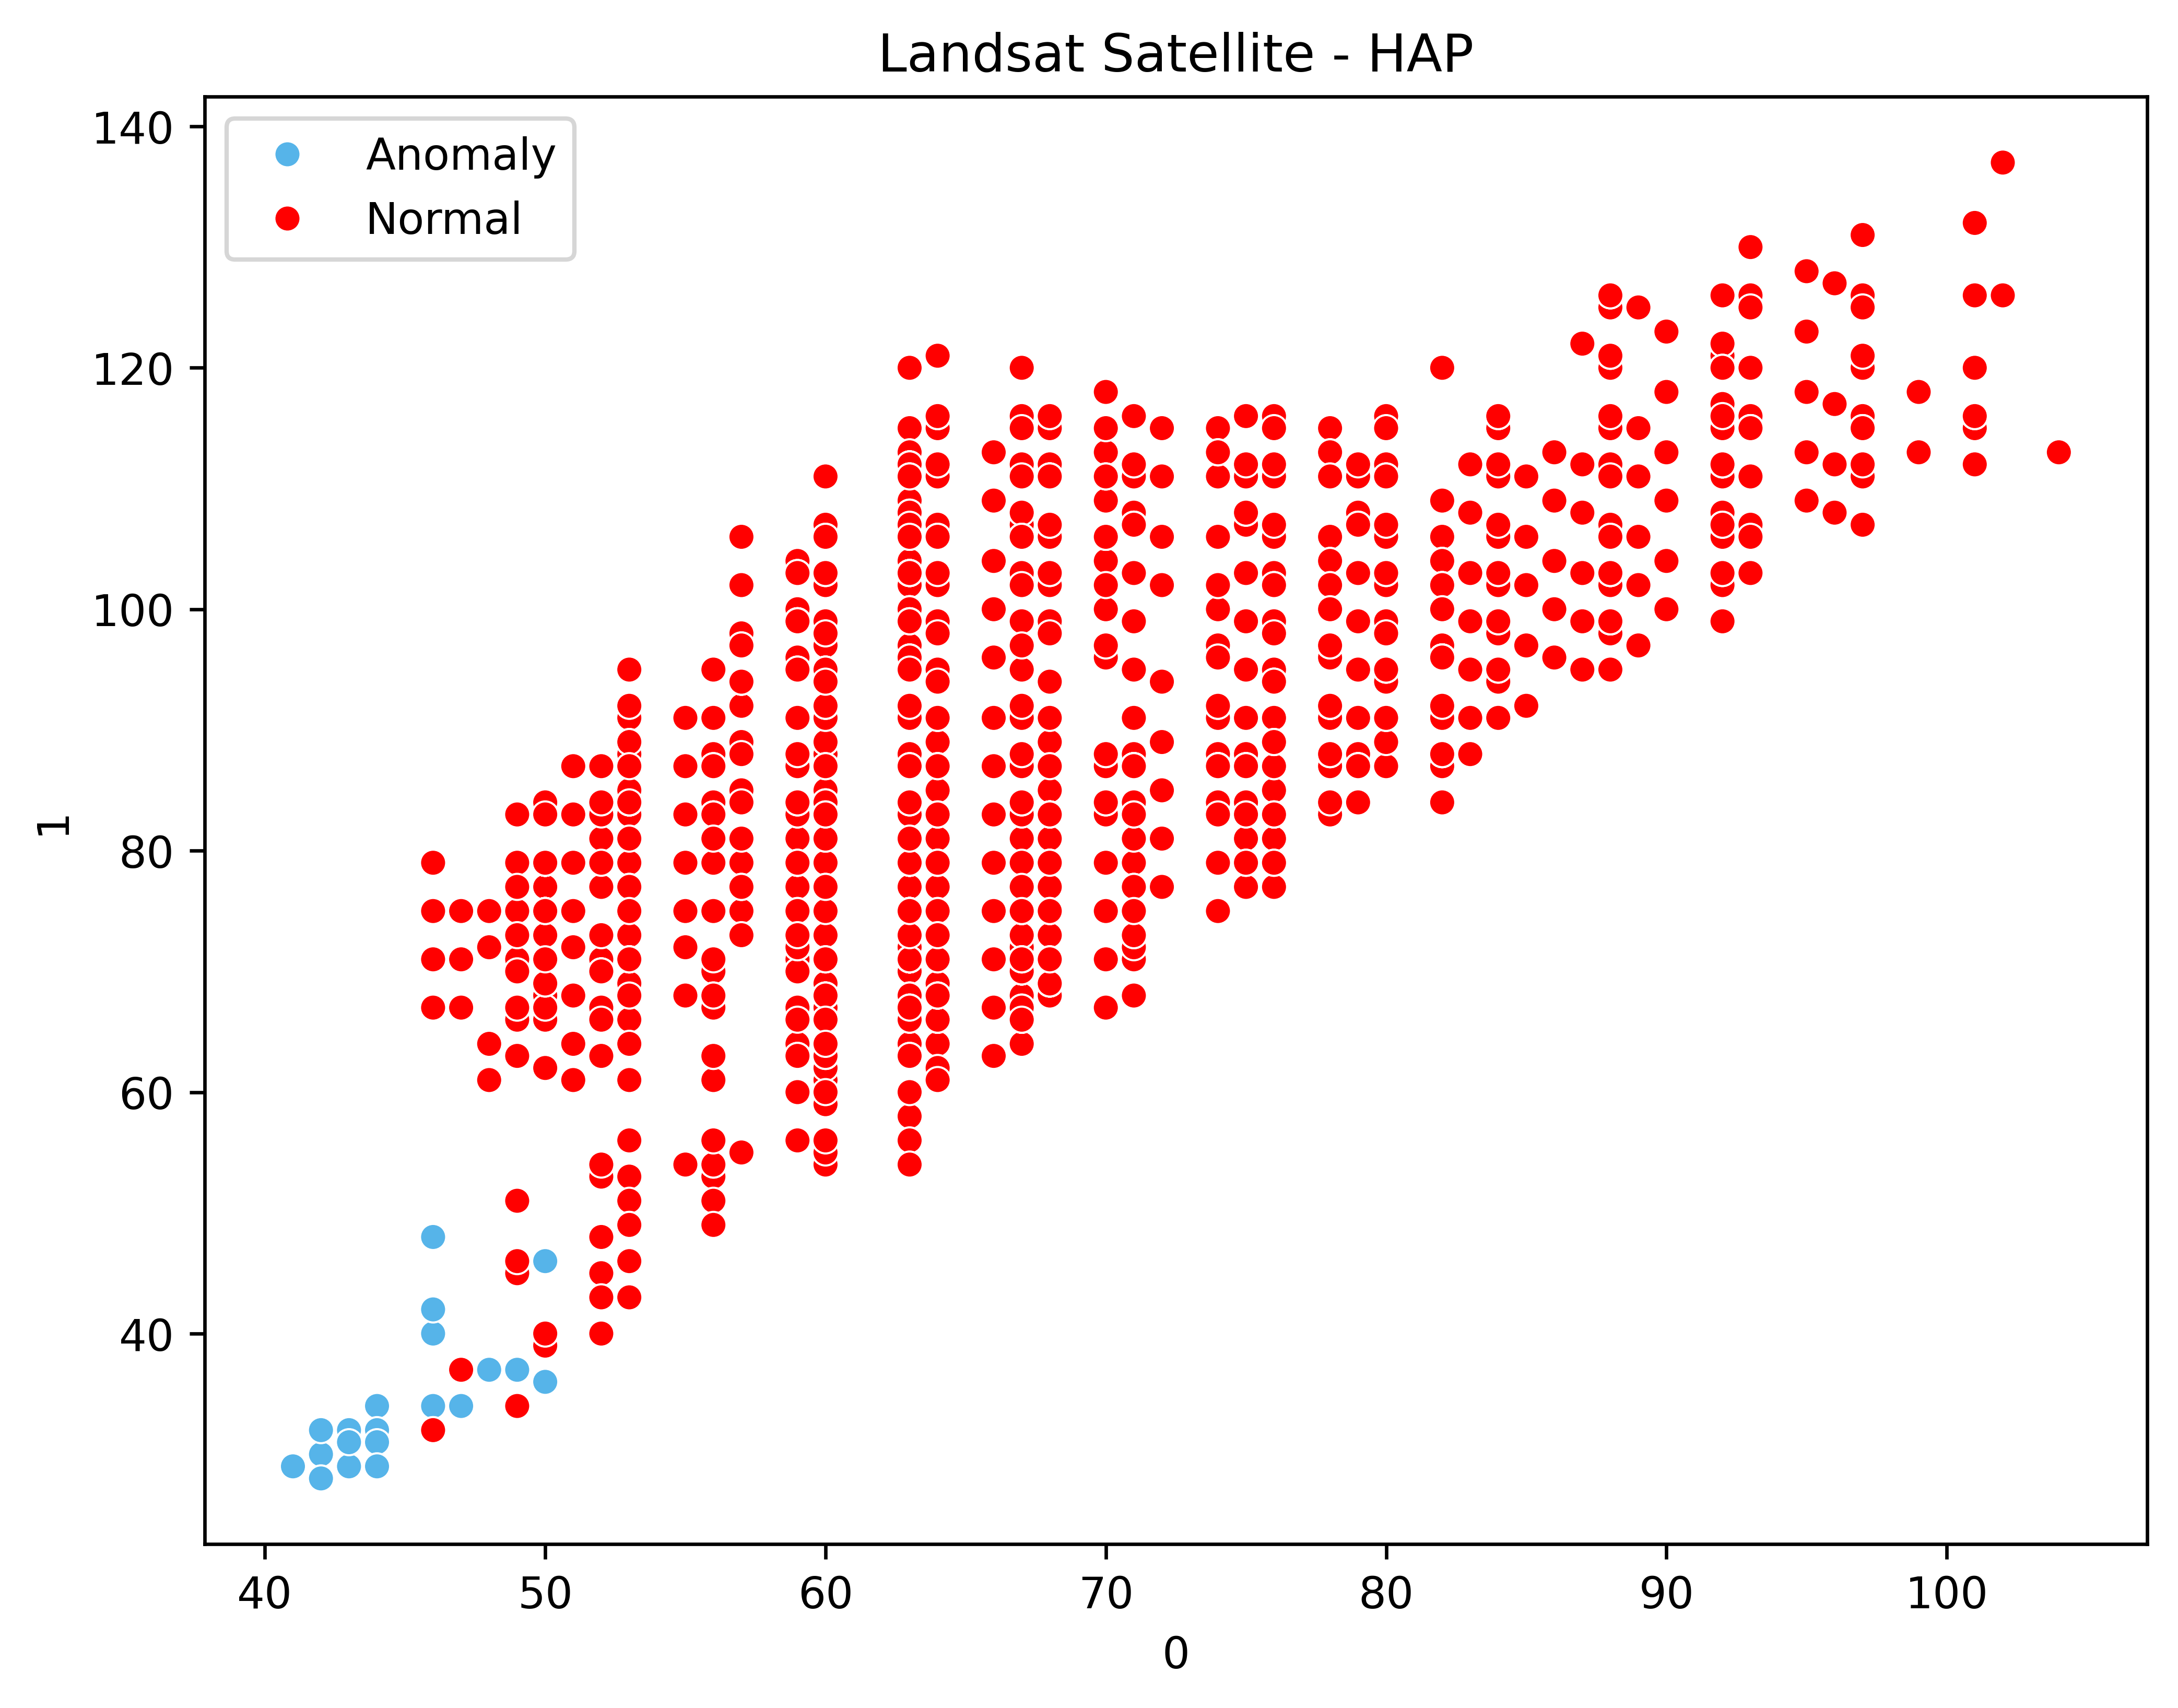

<Figure size 640x480 with 0 Axes>

In [14]:
# Adjusted Rand Index

# Inspect the column for non-integer values
unique_values = satellite_data.iloc[:, 36].unique()
print("Unique values in the column: ", unique_values)

# Clean the column by replacing non-integer values
cleaned_labels_true = pd.to_numeric(satellite_data.iloc[:, 36], errors='coerce').fillna(-1).astype(int)

adjusted_rand = adjusted_rand_score(cleaned_labels_true, agg_labels)
print("Adjusted Rand Index: ", adjusted_rand)

# Visualization for HAP
plt.figure(figsize=(8, 6), dpi=600)
sns.scatterplot(x=satellite_data.iloc[:, 0], y=satellite_data.iloc[:, 1], hue=Label_HAP, palette=["#56B4E9", "red"])
plt.title("Landsat Satellite - HAP")
plt.show()
plt.savefig("satelliteHAP.tiff", dpi=600)
